In [50]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import numpy as np

from brokenaxes import brokenaxes

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [51]:
# CSV 파일에 접근
maml_info = pd.read_csv('../MAML_filter48/MAML_filter48_inner_loop_test.csv')
arbiter_info = pd.read_csv('../MAML+Arbiter_5way_5shot_filter48_7115/MAML+Arbiter_5way_5shot_filter48_inner_loop_test.csv')

# 훈련 정보만 가지고 온다
maml_info_train = maml_info[maml_info['phase']=='val']
arbiter_info_train= arbiter_info[arbiter_info['phase']=='val']

# 1. 정보를 Domain 별로 압축

In [52]:
maml_info_mini_imagenet = maml_info_train[maml_info_train['current_iter']=='mini_imagenet_full_size']

maml_info_mini_imagenet['loss_skewness']  = maml_info_mini_imagenet['loss_skewness'].abs()

maml_info_mini_imagenet = maml_info_mini_imagenet.groupby('num_step')
# maml_info_mini_imagenet

In [53]:
# mini-imagenet
arbiter_info_mini_imagenet = arbiter_info[arbiter_info['current_iter']=='mini_imagenet_full_size']
arbiter_info_mini_imagenet['loss_skewness'] = arbiter_info_mini_imagenet['loss_skewness'].abs()


arbiter_info_mini_imagenet = arbiter_info_mini_imagenet.groupby('num_step')


# # tiered-imagenet
# arbiter_info_tiered_imagenet = arbiter_info[arbiter_info['current_iter']=='tiered_imagenet']
# arbiter_info_tiered_imagenet = arbiter_info_tiered_imagenet.groupby('num_step')
# # CIFAR_FS
# arbiter_info_CIFAR_FS = arbiter_info[arbiter_info['current_iter']=='CIFAR_FS']
# arbiter_info_CIFAR_FS = arbiter_info_CIFAR_FS.groupby('num_step')
# # CUB
# arbiter_info_CUB = arbiter_info[arbiter_info['current_iter']=='CUB']
# arbiter_info_CUB = arbiter_info_CUB.groupby('num_step')

# 'layer_dict.conv0.conv.weight_grad_L2norm', 
# 'layer_dict.conv1.conv.weight_grad_L2norm', 
# 'layer_dict.conv2.conv.weight_grad_L2norm',
# 'layer_dict.conv3.conv.weight_grad_L2norm',
# 'layer_dict.linear.weights_grad_L2norm'

Text(0.5, 1.0, 'Loss Distribution')

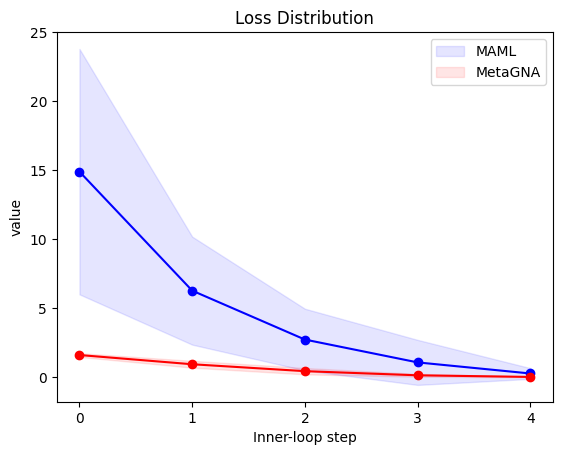

In [54]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['loss_mean'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['loss_mean'].mean()

maml_std_devs = maml_info_mini_imagenet['loss_std'].mean()
arbiter_std_devs= arbiter_info_mini_imagenet['loss_std'].mean()

# maml_mean_df = np.log(maml_mean_df)
# maml_std_devs = np.log(maml_std_devs)

# arbiter_mean_df = np.log(arbiter_mean_df)
# arbiter_std_devs = np.log(arbiter_std_devs)


plt.plot(x, maml_mean_df, '-o', color='b')#, label='MAML')
plt.fill_between(x, maml_mean_df - maml_std_devs, maml_mean_df + maml_std_devs, color='b', alpha=0.1, label='MAML')
plt.plot(x, arbiter_mean_df, '-o', color='r')#, label='MetaGNA')
plt.fill_between(x, arbiter_mean_df - arbiter_std_devs, arbiter_mean_df + arbiter_std_devs, color='r', alpha=0.1, label='MetaGNA')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Loss Distribution')

Text(0.5, 1.0, 'Loss_skewness')

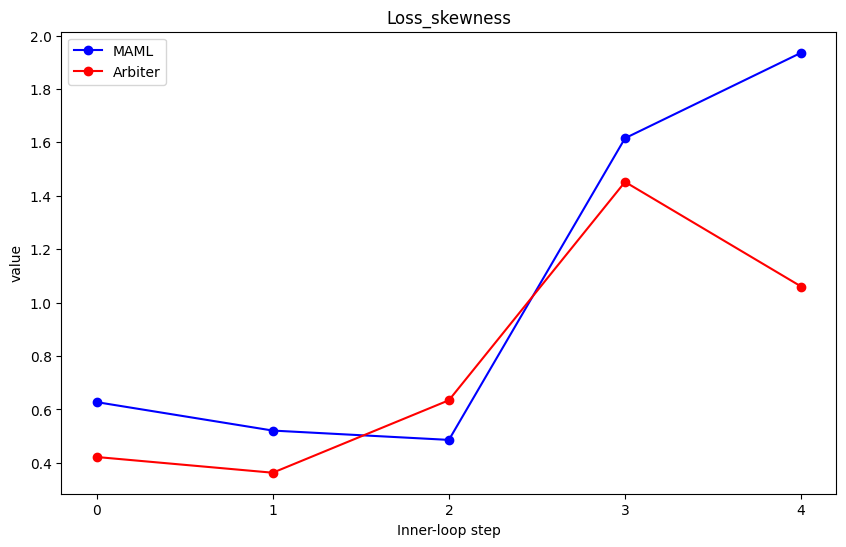

In [62]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))

maml_mean_df = maml_info_mini_imagenet['loss_skewness'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['loss_skewness'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
# maml_means = np.log(maml_means)
# arbiter_means = np.log(arbiter_means)
# arbiter_withoutWN_means = np.log(arbiter_withoutWN_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
# plt.plot(x, before_arbiter_mean_df, '-o', color='g', label='before_Arbiter')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Loss_skewness')

Text(0.5, 1.0, 'Gradient norm')

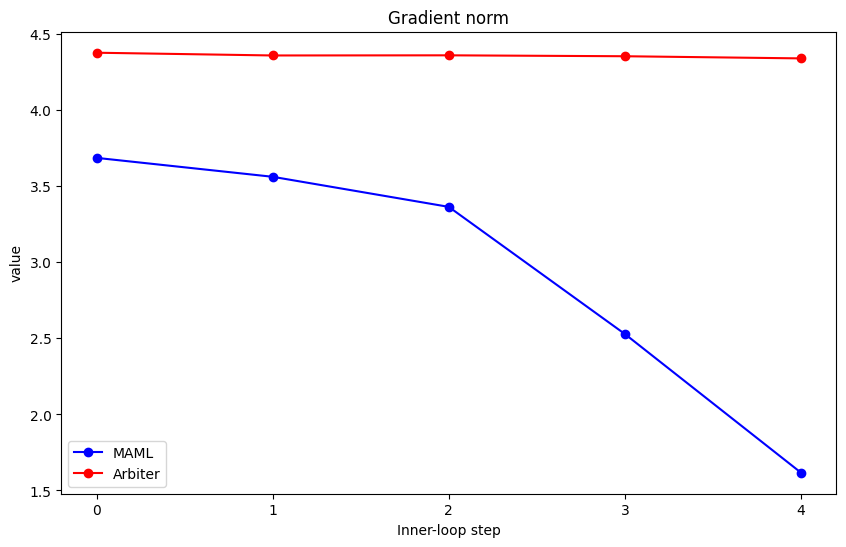

In [56]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_grads_l2norm'].mean()
# before_arbiter_mean_df = arbiter_info_mini_imagenet['pre_all_grads_l2norm'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_grads_l2norm'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
maml_means = np.log(maml_means)
arbiter_means = np.log(arbiter_means)
# arbiter_withoutWN_means = np.log(arbiter_withoutWN_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
# plt.plot(x, before_arbiter_mean_df, '-o', color='g', label='before_Arbiter')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Gradient norm')

Text(0.5, 1.0, 'GSNR')

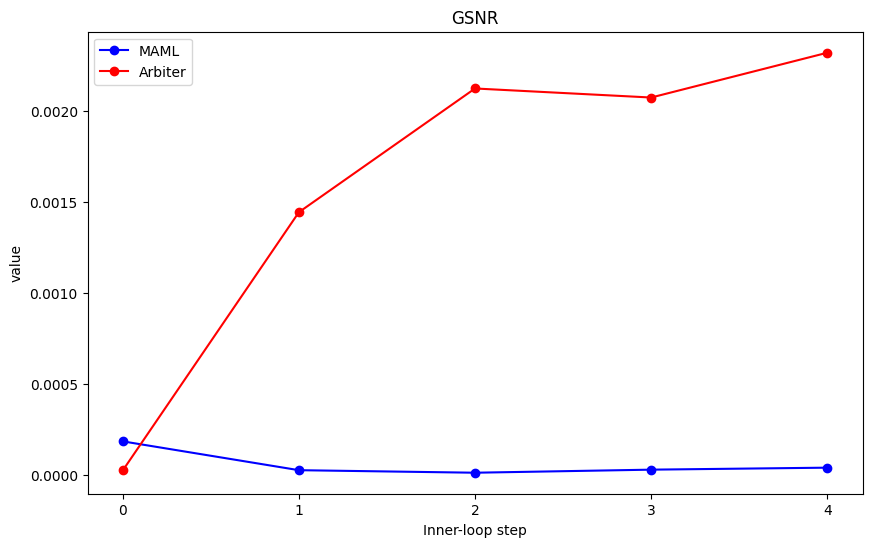

In [57]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['gsnr'].mean()
#arbiter_mean_df = arbiter_info_mini_imagenet['pre_gsnr'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['gsnr'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
# maml_means = np.log(maml_means)
# arbiter_means = np.log(arbiter_means)
# arbiter_withoutWN_means = np.log(arbiter_withoutWN_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('GSNR')

Text(0.5, 1.0, 'Gradient Varaince')

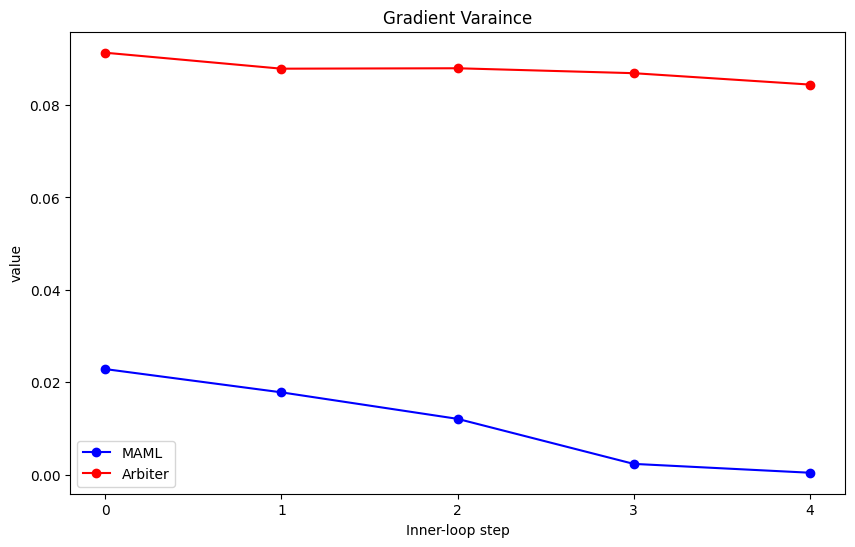

In [58]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_grads_var'].mean()
# arbiter_mean_df = arbiter_info_mini_imagenet['pre_all_grads_var'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_grads_var'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
# maml_means = np.log(maml_means)
# arbiter_means = np.log(arbiter_means)
# arbiter_withoutWN_means = np.log(arbiter_withoutWN_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Gradient Varaince')

Text(0.5, 1.0, 'Gradient mean')

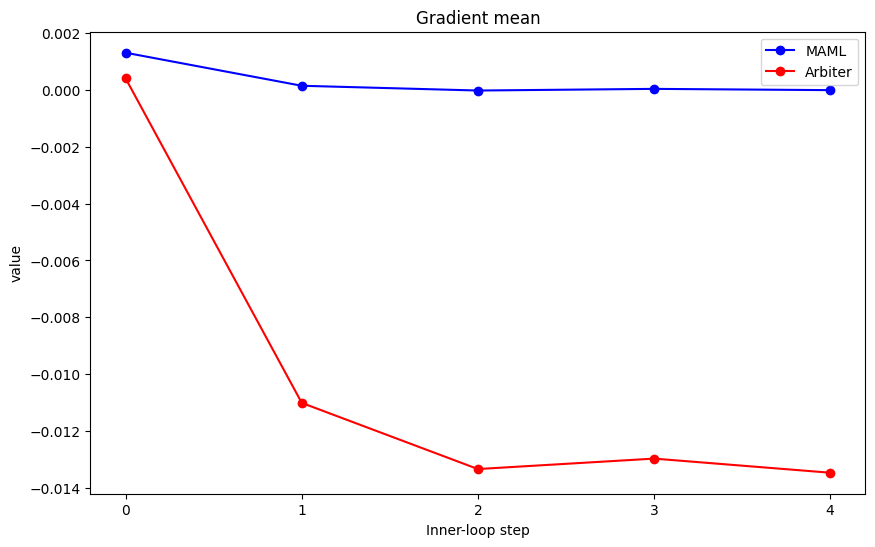

In [59]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_grads_mean'].mean()
# arbiter_mean_df = arbiter_info_mini_imagenet['pre_all_grads_mean'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_grads_mean'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
# maml_means = np.log(maml_means)
# arbiter_means = np.log(arbiter_means)
# arbiter_withoutWN_means = np.log(arbiter_withoutWN_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Gradient mean')

Text(0.5, 1.0, 'Weight norm')

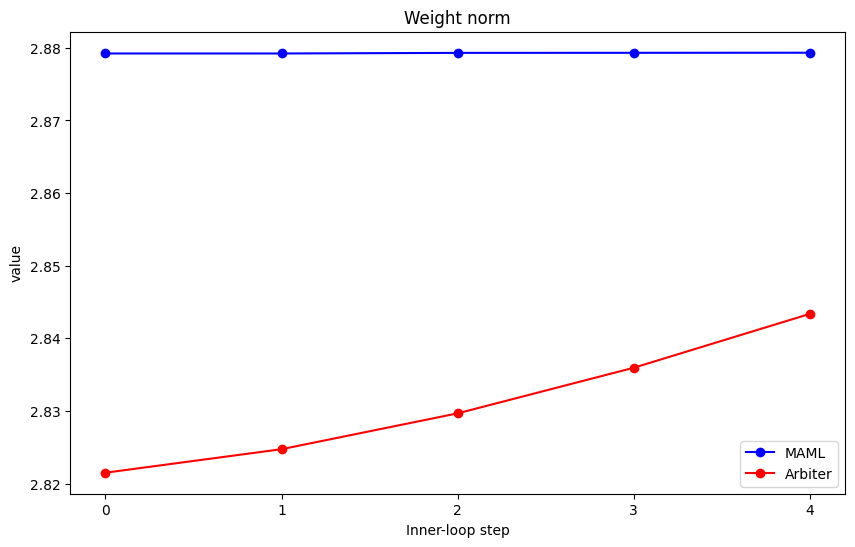

In [60]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_weights_norm'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_weights_norm'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
maml_means = np.log(maml_means)
arbiter_means = np.log(arbiter_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Weight norm')

Text(0.5, 1.0, 'Weight variance')

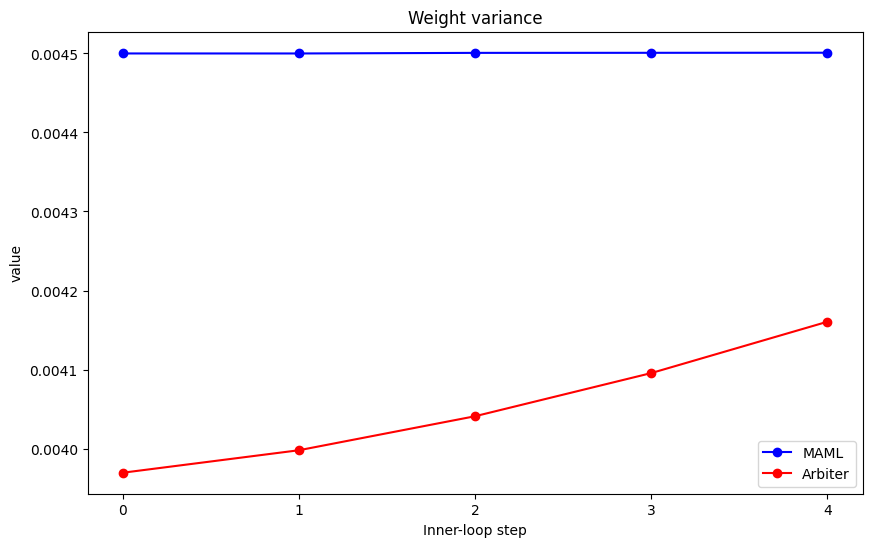

In [61]:
group_names = []

for name, group in maml_info_mini_imagenet:
    # 그룹 이름을 저장 (모든 그룹은 동일한 순서로 추가됨)
    if name not in group_names:
        group_names.append(name)

x = range(len(group_names))
        
maml_mean_df = maml_info_mini_imagenet['all_weights_var'].mean()
arbiter_mean_df = arbiter_info_mini_imagenet['all_weights_var'].mean()

maml_means = maml_mean_df.values
arbiter_means = arbiter_mean_df.values

# 데이터에 로그 변환 적용
# maml_means = np.log(maml_means)
# arbiter_means = np.log(arbiter_means)

# 꺾은선 그래프를 그립니다
plt.figure(figsize=(10, 6))
plt.plot(x, maml_means, '-o', color='b', label='MAML')
plt.plot(x, arbiter_means, '-o', color='r', label='Arbiter')
# plt.plot(x, arbiter_withoutWN_means, '-o', color='g', label='Arbiter_withoutWN')
# plt.plot(x, arbiter_withoutGN_means, '-o', color='violet', label='Arbiter_withoutGN')

plt.legend()
plt.xticks(x, group_names)
plt.xlabel('Inner-loop step')
plt.ylabel('value')
plt.title('Weight variance')